In [1]:
%load_ext autoreload
%autoreload 2 
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [1]:
%load_ext autoreload
%autoreload 2 
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

# enable 16 bit precision for jax                                                                                                                             
from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax import jit, grad, random

import numpyro
import numpyro.distributions as dist
MultivariateNormal = dist.MultivariateNormal
import optax

# Import GSM                                                                                                                                                  
import sys
sys.path.append('../src/')
from gsm import GSM
from advi import ADVI
from ngd import NGD
from pathfinder import Pathfinder
#####                                                                                                                                                         
from initializers import lbfgs_init

sys.path.append('../utils/')
from monitors import KLMonitor_Gauss as Monitor

import tensorflow_probability as tfp
SinhArcsinh = tfp.substrates.jax.distributions.SinhArcsinh
MultivariateNormal_tf = tfp.substrates.jax.distributions.MultivariateNormalFullCovariance


/mnt/home/cmodi/miniconda3/envs/jaxenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tfp.substrates.jax.distributions.MultivariateNormalFullCovariance

tensorflow_probability.substrates.jax.distributions.mvn_full_covariance.MultivariateNormalFullCovariance

In [4]:
sys.path.append('../../posterior_database/')
from posteriordb import PDB, BSDB
names = np.loadtxt('../../posterior_database/pdbnames.txt', dtype='str')


# Simple multivariate Gaussian

In [5]:
##### Simple experiment for multivaraite Gaussian with dense covariance matrix
#####                                                                                                                                                         
def setup_model(D=10):

    # setup a Gaussian target distribution                                                                                                                    
    mean = np.random.random(D)
    L = np.random.normal(size = D**2).reshape(D, D)
    cov = np.matmul(L, L.T) + np.eye(D)*1e-3
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 5000)
    return model, mean, cov, lp, lp_g, ref_samples


def setup_sinh_arcsinh_model(D, s, t, seed=0):

    np.random.seed(seed)
    mean = np.random.random(D)
    L = np.random.normal(size = D**2).reshape(D, D)
    cov = np.matmul(L, L.T) + np.eye(D)*1e-3
    scale = np.diagonal(cov)
    skewness = np.random.uniform(0, 1.0, D)
    tailweight = np.random.uniform(0.5, 1.5, D)
    model = SinhArcsinh(mean, scale, skewness=skewness, tailweight=tailweight)                        
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    rng = jax.random.PRNGKey(0)
    ref_samples = model.sample(5000, rng)
    return model, mean, cov, lp, lp_g, ref_samples


D = 4
model, mean, cov, lp, lp_g, ref_samples = setup_model(D)

# s = 1.8
# t = 0.5
# model, mean, cov, lp, lp_g, ref_samples = setup_sinh_arcsinh_model(D=D, s=s, t=t)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
def gsm_fit(D, lp, lp_g, niter=1000, batch_size=2, monitor=None):
    gsm = GSM(D=D, lp=lp, lp_g=lp_g)
    key = random.PRNGKey(99)
    mean_fit, cov_fit = gsm.fit(key, niter=niter, monitor=monitor, batch_size=batch_size)
    return mean_fit, cov_fit


def advi_fit(D, lp, lp_g, lr=1e-2, batch_size=16, niter=1000, monitor=None):
    advi = ADVI(D=D, lp=lp)
    key = random.PRNGKey(99)
    opt = optax.adam(learning_rate=lr)
    mean_fit, cov_fit, losses = advi.fit(key, opt, batch_size=batch_size, 
                                         niter=niter, monitor=monitor)
    return mean_fit, cov_fit


def ngd_fit(D, lp, lp_g, lr=1e-2, batch_size=16, niter=1000, reg=1e-5, monitor=None):
    ngd = NGD(D=D, lp=lp, lp_g=lp_g)
    key = random.PRNGKey(99)
    mean_fit, cov_fit = ngd.fit(key, lr=lr, batch_size=batch_size, reg=reg, niter=niter, monitor=monitor)
    return mean_fit, cov_fit
    


In [7]:
params = {}

alg = "gsm"
monitorg = Monitor(batch_size=2, ref_samples=ref_samples)
params[alg] = gsm_fit(D, lp, lp_g, monitor=monitorg, niter=100)

# monitorg2 = Monitor(batch_size=1000, ref_samples=ref_samples)
# params['gsm2'] = gsm_fit(D, lp, lp_g, monitor=monitorg2, niter=5000, batch_size=8)

# monitorg3 = Monitor(batch_size=1000, ref_samples=ref_samples)
# params['gsm3'] = gsm_fit(D, lp, lp_g, monitor=monitorg3, niter=5000, batch_size=32)

# alg = "advi"
# monitorb = Monitor(batch_size=32, ref_samples=ref_samples)
# params[alg] = advi_fit(D, lp, lp_g, monitor=monitorb, lr=1e-2, batch_size=8, niter=20000)

# alg = "advi3"
# monitorb2 = Monitor(batch_size=32, ref_samples=ref_samples)
# params[alg] = advi_fit(D, lp, lp_g, monitor=monitorb2, lr=1e-2, batch_size=32, niter=10000)

# # alg = "ngd"
# # monitorn = Monitor(batch_size=32, ref_samples=ref_samples)
# # params[alg] = ngd_fit(D, lp, lp_g, monitor=monitorn, lr=1e-1, batch_size=2, reg=1e-5, niter=5000)


Iteration 0 of 100
Iteration 10 of 100
Iteration 20 of 100
Iteration 30 of 100
Iteration 40 of 100
Iteration 50 of 100
Iteration 60 of 100
Iteration 70 of 100
Iteration 80 of 100
Iteration 90 of 100
Iteration 100 of 100


In [58]:
# alg = "gsm"
# # monitorg = Monitor(batch_size=32, ref_samples=ref_samples)
# for niters in range(4000, 5000, 200):
#     params[alg+f'{niters}'] = gsm_fit(D, lp, lp_g, monitor=None, niter=niters, batch_size=8)


Text(0.5, 0, '# grad evals')

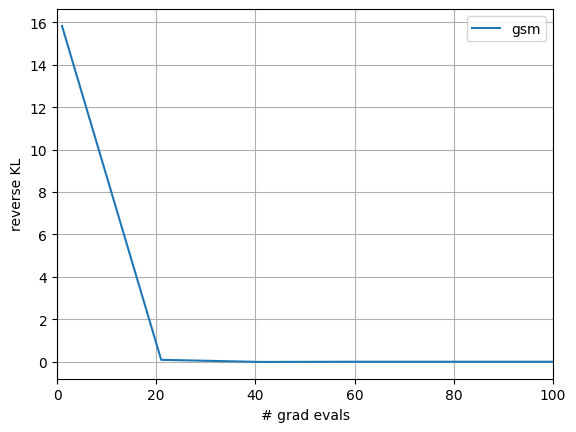

In [63]:
plt.plot(monitorg.nevals, monitorg.bkl, label='gsm')
# plt.plot(monitorg2.nevals, monitorg2.bkl, label='gsm8')
# plt.plot(monitorg3.nevals, monitorg3.bkl, label='gsm32')
# plt.plot(monitorb.nevals, monitorb.bkl, label='bbvi')
# plt.plot(monitorb2.nevals, monitorb2.bkl, label='bbvi32')
# plt.plot(monitorn.nevals, monitorn.bkl, label='ngd')
# plt.xscale('log')
plt.ylabel('reverse KL')
plt.grid(which='both')
# plt.loglog()
plt.legend()
plt.xlim(0, 100)
plt.xlabel("# grad evals")

[]

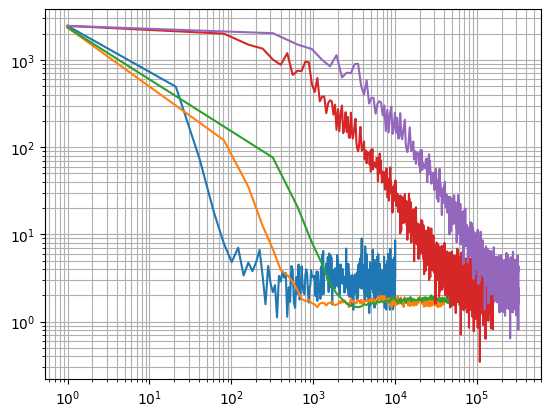

In [30]:
plt.plot(monitorg.nevals, monitorg.fkl, label='gsm')
plt.plot(monitorg2.nevals, monitorg2.fkl, label='gsm8')
plt.plot(monitorg3.nevals, monitorg3.fkl, label='gsm32')
plt.plot(monitorb.nevals, monitorb.fkl)
plt.plot(monitorb2.nevals, monitorb2.fkl)
# plt.plot(monitorn.nevals, monitorn.fkl)
# plt.xscale('log')
plt.grid(which='both')
plt.loglog()

In [16]:
# z = ref_samples[0]
# zz = np.dot(np.linalg.inv(cov), z - mean).reshape(1, -1)
# a = np.expand_dims(np.transpose(zz), 1)
# b = np.expand_dims(lp_g(z).reshape(1, -1), -1)

# (a*b)[..., 0]/(a*b)[..., 0].T

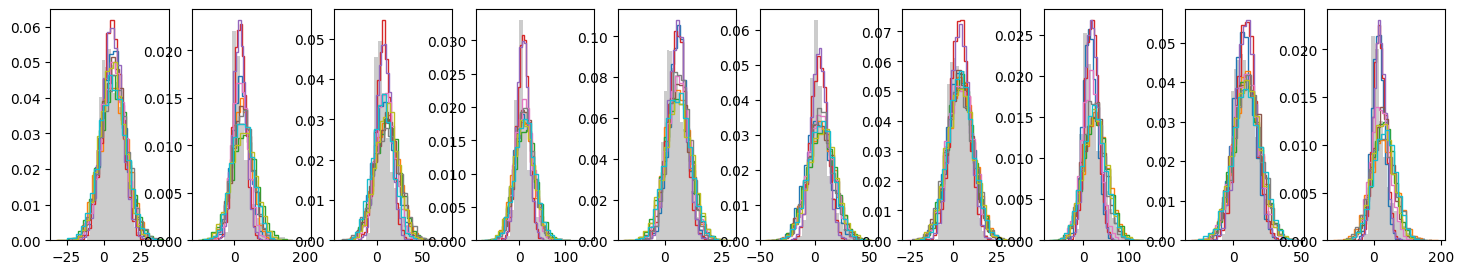

In [17]:
Dplot = min(10, D)
fig, ax = plt.subplots(1, Dplot, figsize=(18, 3), sharey=False)

for alg in params.keys():
    samples = np.random.multivariate_normal(params[alg][0], params[alg][1], 5000)
    for i in range(Dplot):
        ax[i].hist(samples[:, i], alpha=1., label=alg, histtype='step', bins=20, density=True)
                
for i in range(Dplot):
    ax[i].hist(ref_samples[:, i], alpha=0.2, label='Ref', color='k', bins=20, density=True)
    
# ax[-1].legend()

In [18]:
params.keys()

dict_keys(['gsm', 'gsm2', 'gsm3', 'advi', 'advi3', 'gsm4000', 'gsm4200', 'gsm4400', 'gsm4600', 'gsm4800'])

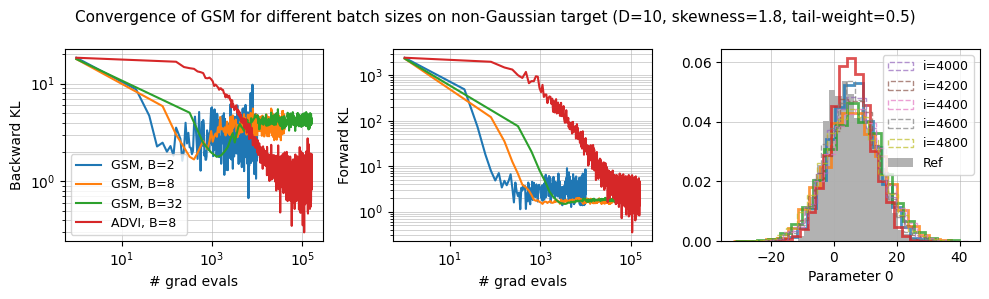

In [31]:
lbls = ['GSM, B=2', 'GSM, B=8', 'GSM, B=32', 'ADVI, B=8']

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].plot(monitorg.nevals, monitorg.bkl, label=lbls[0])
ax[0].plot(monitorg2.nevals, monitorg2.bkl, label=lbls[1])
ax[0].plot(monitorg3.nevals, monitorg3.bkl, label=lbls[2])
ax[0].plot(monitorb.nevals, monitorb.bkl, label=lbls[3])
ax[0].loglog()
ax[0].legend(loc=3, fontsize=9)
ax[0].set_ylabel('Backward KL')
ax[0].set_xlabel('# grad evals')

ax[1].plot(monitorg.nevals, monitorg.fkl)
ax[1].plot(monitorg2.nevals, monitorg2.fkl)
ax[1].plot(monitorg3.nevals, monitorg3.fkl)
ax[1].plot(monitorb.nevals, monitorb.fkl)
ax[1].loglog()
ax[1].set_ylabel('Forward KL')
ax[1].set_xlabel('# grad evals')

for ia, alg in enumerate(['gsm', 'gsm2', 'gsm3', 'advi']):
    samples = np.random.multivariate_normal(params[alg][0], params[alg][1], 5000)
    ax[2].hist(samples[:, 0], alpha=0.8, histtype='step', bins=20, density=True, lw=2, label=None)
    
for i in range(4000, 5000, 200):
    alg = f'gsm{i}' 
    samples = np.random.multivariate_normal(params[alg][0], params[alg][1], 5000)
    ax[2].hist(samples[:, 0], alpha=0.7, histtype='step', bins=20, density=True, lw=1.0, ls='--', label=f'i={i}')
ax[2].hist(ref_samples[:, 0], alpha=0.3, label='Ref', color='k', bins=20, density=True);
ax[2].legend(fontsize=9)
ax[2].set_xlabel('Parameter 0')

for axis in ax:
    axis.grid(which='both', lw=0.4)
plt.suptitle(f"Convergence of GSM for different batch sizes on non-Gaussian target (D={D}, skewness={s}, tail-weight={t})", fontsize=11)
plt.tight_layout()


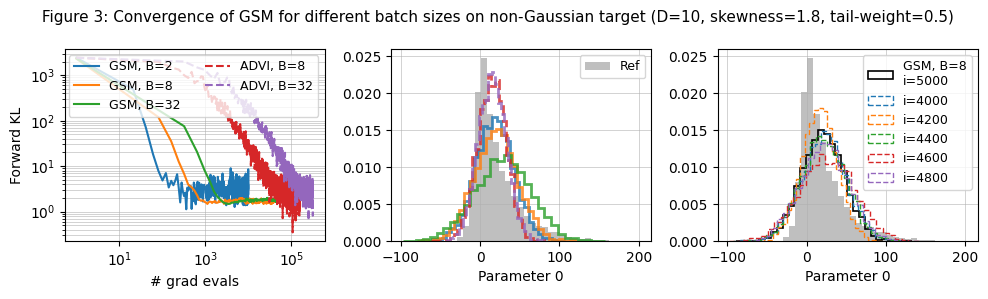

In [82]:
lbls = ['GSM, B=2', 'GSM, B=8', 'GSM, B=32', 'ADVI, B=8', 'ADVI, B=32']

fig, ax = plt.subplots(1, 3, figsize=(10, 3))

ax[0].plot(monitorg.nevals, monitorg.fkl, label=lbls[0])
ax[0].plot(monitorg2.nevals, monitorg2.fkl, label=lbls[1])
ax[0].plot(monitorg3.nevals, monitorg3.fkl, label=lbls[2])
ax[0].plot(monitorb.nevals, monitorb.fkl, label=lbls[3], ls='--')
ax[0].plot(monitorb2.nevals, monitorb2.fkl, label=lbls[4], ls='--')
ax[0].loglog()
ax[0].set_ylabel('Forward KL')
ax[0].set_xlabel('# grad evals')
ax[0].legend(loc=1, fontsize=9, ncol=2)


##
ip = 1
for ia, alg in enumerate(['gsm', 'gsm2', 'gsm3']):
    samples = np.random.multivariate_normal(params[alg][0], params[alg][1], 5000)
    ax[1].hist(samples[:, ip], alpha=0.8, histtype='step', bins=30, density=True, lw=2, label=None)
for ia, alg in enumerate([ 'advi', 'advi3']):
    samples = np.random.multivariate_normal(params[alg][0], params[alg][1], 5000)
    ax[1].hist(samples[:, ip], alpha=0.8, histtype='step', bins=30, density=True, lw=2, label=None, ls='--')
ax[1].hist(ref_samples[:, ip], alpha=0.25, label='Ref', color='k', bins=30, density=True);
ax[1].legend(fontsize=9, ncol=2)
ax[1].set_xlabel('Parameter 0')
    
##
alg = f'gsm2' 
samples = np.random.multivariate_normal(params[alg][0], params[alg][1], 5000)
ax[2].hist(samples[:, ip], alpha=1.0, histtype='step', bins=30, density=True, lw=1.2, ls='-',  color='k', label='GSM, B=8\ni=5000')
for i in range(4000, 5000, 200):
    alg = f'gsm{i}' 
    samples = np.random.multivariate_normal(params[alg][0], params[alg][1], 5000)
    ax[2].hist(samples[:, ip], alpha=1., histtype='step', bins=30, density=True, lw=1.0, ls='--', label=f'i={i}')
ax[2].hist(ref_samples[:, ip], alpha=0.25, label='', color='k', bins=30, density=True);
ax[2].legend(fontsize=9)
ax[2].set_xlabel('Parameter 0')

for axis in ax:
    axis.grid(which='both', lw=0.4)
plt.suptitle(f" Figure 3: Convergence of GSM for different batch sizes on non-Gaussian target (D={D}, skewness={s}, tail-weight={t})", fontsize=11)
plt.tight_layout()


NameError: name 'params' is not defined

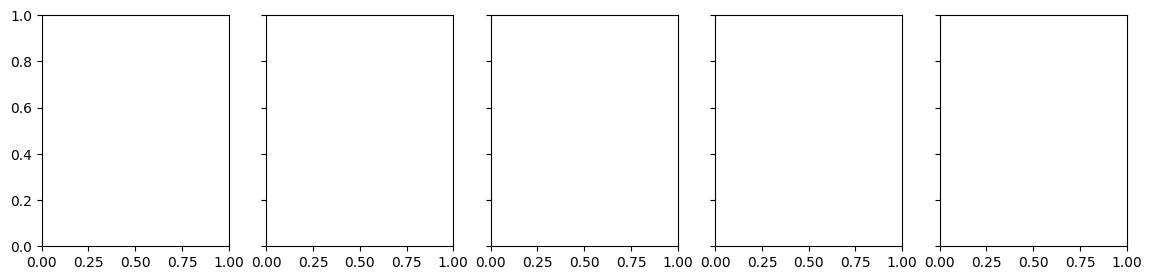

In [9]:
# Dplot = min(5, D)
# fig, ax = plt.subplots(1, Dplot, figsize=(14, 3), sharey=True)

# for alg in params.keys():
#     samples = np.random.multivariate_normal(params[alg][0], params[alg][1], 5000)
#     for i in range(Dplot):
#         ax[i].hist(samples[:, i], alpha=0.3, label=alg)
                
# for i in range(Dplot):
#     ax[i].hist(ref_samples[:, i], alpha=1.0, label='Ref', lw=2, histtype='step', color='k')
    
# ax[-1].legend()

# NGD

In [24]:
from functools import partial
from jax import grad, hessian

@jit
def lp_gauss(x, mu, cov):
    q = dist.MultivariateNormal(mu, cov)
    return q.log_prob(x)

@jit
def lp_gauss_sum(x, mu, cov):
    q = dist.MultivariateNormal(mu, cov)
    return jnp.sum(q.log_prob(x))

@jit
def lp_gauss_sum_score(x, mu, cov):
    return grad(lp_gauss_sum, argnums=0)(x, mu, cov)

@jit
def lp_gauss_sum_score2(x, mu, cov):
    icov = jnp.linalg.inv(cov)
    return -jnp.dot(icov, (x-mu).T).T
    # return jax.vmap(lambda x: -jnp.dot(icov, (x - mu)))(x)

@partial(jit, static_argnums=(1))
def sample_gauss(key, n, mu, cov):
    q = dist.MultivariateNormal(mu, cov)
    sample = q.sample(key, (n,))
    return sample


@jit
def loss(z, mu, cov):
    q = dist.MultivariateNormal(mu, cov)
    hz = jnp.sum(q.log_prob(z)) - jnp.sum(lp(z)) 
    return hz
    
grad_loss = jit(grad(loss, argnums=0))
hess_loss = jit(hessian(loss, argnums=0))



def ngd_update(lp, lpg, mu, cov, batch=8, lr=1e-1, reg=1e-5):
    
    icov = np.linalg.inv(cov)
    z = np.random.multivariate_normal(mu, cov, size=batch)   
    l = np.stack([loss(zz, mu, cov) for zz in z], axis=0).mean(axis=0)
    g0 = lpg(z)
    g1 = lp_gauss_sum_score(z, mu, cov)
    g = np.mean(g1 - g0, axis=0)
    
    # h = np.stack([hess_loss(zz, mu, cov) for zz in z], axis=0).mean(axis=0)    
    h_gn = np.stack([np.outer(gg, gg) for gg in g0], axis=0).mean(axis=0)
    h = - icov + h_gn
    h += np.eye(mu.size)*reg
    icovnew = icov + lr * h    
    covnew = np.linalg.inv(icovnew)
    munew = mu - lr * np.dot(covnew, g)
    return l, munew, covnew




In [25]:
# z = ref_samples[0]
# mean_fit, cov_fit = np.random.normal(size=D), np.eye(D)*1.0
# hess_loss(z, mean_fit, cov_fit)
# hessian(lp)(zz[0]), - np.linalg.inv(cov)

# zz = ref_samples[:8]
# gg = [grad_loss(z, mean_fit, cov_fit) for z in zz]
# np.mean([np.outer(g, g) for g in gg], axis=0)

In [26]:
def check_cov(i, mu_new, cov_new, mu_update, cov_update, det_thresh=1e-16):

    # det = np.linalg.det(cov_new)
    # if abs(det) < det_thresh:
    #     print("0 determinant")
    #     return  mu_update, cov_update 
    try:
        if (np.isnan(np.linalg.cholesky(cov_new))).any():            
            print("nan in cholesky")
            return mu_update, cov_update
        else:
            return mu_new, cov_new
    except Exception as e:
        print(f"Exception in checking cov at iteration {i}: ", e)
        return mu_update, cov_update

In [27]:
key = random.PRNGKey(10)
key, key_sample = random.split(key, 2)

In [16]:

mean_fit, cov_fit = np.zeros(D), np.eye(D)*1.0
monitorn = Monitor()
monitorn(0, [mean_fit, cov_fit], lp, key, nevals=1)

niter = 100
batch = 1
lr = 1.
reg = 1e-8

losses = []
for i in range(niter+1):
    if i%100 == 0 :print(i)
    # l, mean_new, cov_new = ngd_update(mean_fit, cov_fit, lr=lr, batch=batch, reg=reg)
    l, mean_new, cov_new = ngd_update(lp, lp_g, mean_fit, cov_fit, lr=lr, batch=batch, reg=reg)
    mean_fit, cov_fit = check_cov(i, mean_new, cov_new, mean_fit, cov_fit)

    key, key_sample = random.split(key, 2)
    monitorn(i, [mean_fit, cov_fit], lp, key, nevals=batch)

    losses.append(l)
    
samples_ngd = np.random.multivariate_normal(mean_fit, cov_fit, 5000)
samples_gsm = np.random.multivariate_normal(params['gsm'][0], params['gsm'][1], 5000)


mean_fit, cov_fit = np.zeros(D), np.eye(D)*1.0
monitorn2 = Monitor()
monitorn2(0, [mean_fit, cov_fit], lp, key, nevals=1)

niter = 100
batch = 1
lr = 0.1
reg = 1e-8

losses = []
for i in range(niter+1):
    if i%100 == 0 :print(i)
    # l, mean_new, cov_new = ngd_update(mean_fit, cov_fit, lr=lr, batch=batch, reg=reg)
    l, mean_new, cov_new = ngd_update(lp, lp_g, mean_fit, cov_fit, lr=lr, batch=batch, reg=reg)
    mean_fit, cov_fit = check_cov(i, mean_new, cov_new, mean_fit, cov_fit)

    key, key_sample = random.split(key, 2)
    monitorn2(i, [mean_fit, cov_fit], lp, key, nevals=batch)

    losses.append(l)
    
samples_ngd = np.random.multivariate_normal(mean_fit, cov_fit, 5000)
samples_gsm = np.random.multivariate_normal(params['gsm'][0], params['gsm'][1], 5000)


0
100
0
100


In [17]:
# lp(zz[0]), lp(zz[1]), lp(zz[:2])

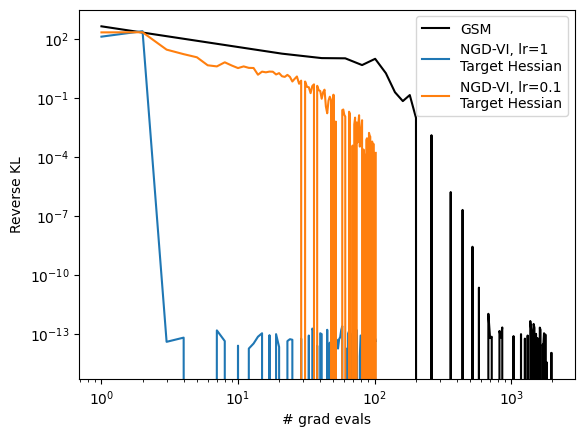

In [18]:
# plt.plot(losses)
plt.plot(monitorg.nevals, monitorg.bkl, label='GSM', color='k')
plt.plot(monitorn.nevals, monitorn.bkl, label='NGD-VI, lr=1\nTarget Hessian')
plt.plot(monitorn2.nevals, monitorn2.bkl, label='NGD-VI, lr=0.1\nTarget Hessian')
plt.loglog()
plt.xlabel("# grad evals")
plt.ylabel("Reverse KL")
plt.legend()

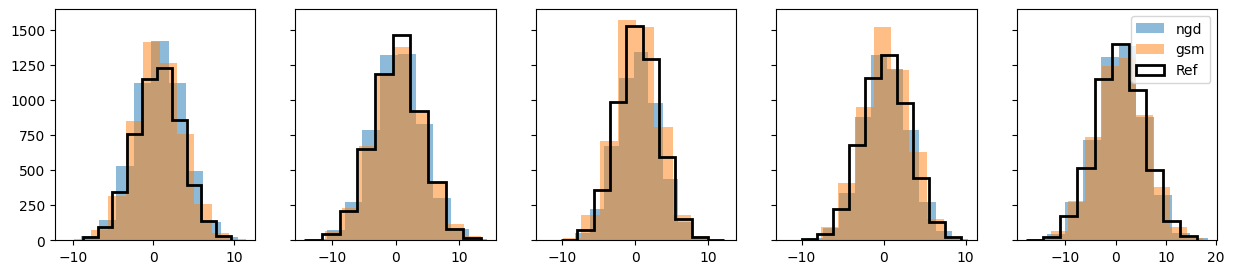

In [19]:
Dplot = min(5, D)
fig, ax = plt.subplots(1, Dplot, figsize=(15, 3), sharey=True)

for i in range(Dplot):
    ax[i].hist(samples_ngd[:, i], alpha=0.5, label='ngd')
    ax[i].hist(samples_gsm[:, i], alpha=0.5, label='gsm')

for i in range(Dplot):
    ax[i].hist(ref_samples[:, i], alpha=1.0, label='Ref', lw=2, histtype='step', color='k')
ax[-1].legend()

In [718]:
zz = ref_samples[:4]
loss(zz, mean_fit, cov_fit)

Array(-1213836.51819058, dtype=float64)

In [719]:
from monitors import backward_kl_gauss
backward_kl_gauss(zz, mean_fit, cov_fit, lp)

Array(-1213836.51819058, dtype=float64)

# check files

In [42]:
path = '/mnt/ceph/users/cmodi/polyakVI/gsmpaper_rebuttal/FRG/'

B = 2
lr = 1e-2
D = 64
algs = ['gsm', 'advi', 'ngd']
keys = ['mean', 'cov', 'nevals', 'bkl', 'fkl']
res = {}
        
mean = np.load(f"{path}/D{D}/mean.npy")
cov = np.load(f"{path}/D{D}/cov.npy")
ref_samples = np.random.multivariate_normal(mean, cov, size=5000)
for alg in algs:
    res[alg] = {}
    if alg == 'gsm':
        apath = f"{path}/D{D}/{alg}/B{B}/"
    else:
        apath = f"{path}/D{D}/{alg}/B{B}-lr{lr:0.3f}/"
    
    for key in keys:
        res[alg][key] = np.load(f"{apath}/{key}.npy")


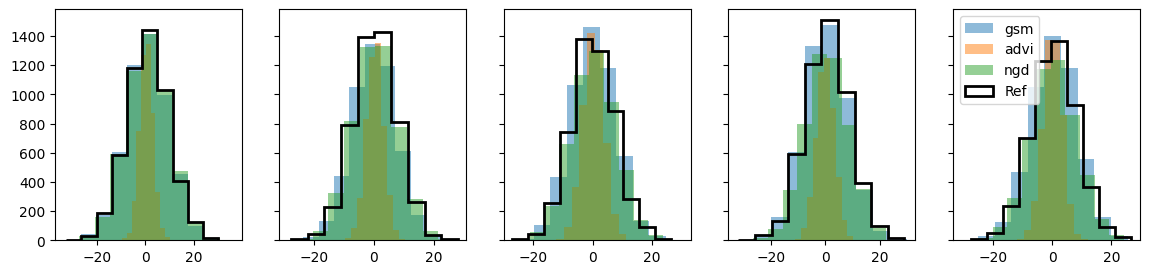

In [46]:
Dplot = min(5, D)
fig, ax = plt.subplots(1, Dplot, figsize=(14, 3), sharey=True)

for alg in algs:
    samples = np.random.multivariate_normal(res[alg]['mean'], res[alg]['cov'], 5000)
    for i in range(Dplot):
        ax[i].hist(samples[:, i], alpha=0.5, label=alg)
                
for i in range(Dplot):
    ax[i].hist(ref_samples[:, i], alpha=1.0, label='Ref', lw=2, histtype='step', color='k')
    
ax[-1].legend()

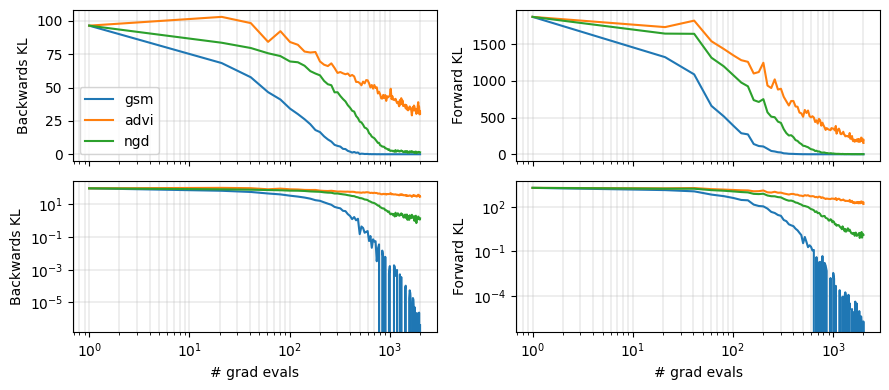

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(9, 4), sharex=True)

for alg in algs:
    ax[0, 0].plot(res[alg]['nevals'], res[alg]['bkl'], label=alg)    
    ax[0, 1].plot(res[alg]['nevals'], res[alg]['fkl'], label=alg)    
    ax[1, 0].plot(res[alg]['nevals'], res[alg]['bkl'], label=alg)    
    ax[1, 1].plot(res[alg]['nevals'], res[alg]['fkl'], label=alg)    

ax[0, 0].legend()
for axis in ax.flatten():
    axis.semilogx()
    axis.grid(which='both', lw=0.3)
    
for axis in ax[:, 0]:
    axis.set_ylabel("Backwards KL")
for axis in ax[:, 1]:
    axis.set_ylabel("Forward KL")
for axis in ax[1]:
    axis.set_xlabel("# grad evals")
    axis.semilogy()
    
plt.tight_layout()

# hyperparamters

In [50]:
path = '/mnt/ceph/users/cmodi/polyakVI/gsmpaper_rebuttal/FRG/'

keys = ['mean', 'cov', 'nevals', 'bkl', 'fkl']
D = 16
mean = np.load(f"{path}/D{D}/mean.npy")
cov = np.load(f"{path}/D{D}/cov.npy")
ref_samples = np.random.multivariate_normal(mean, cov, size=5000)


res = {}
res2 = {}
lrs = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2] #64
lrs = [0.005, 0.01, 0.02, 0.05] #16
# lrs = [0.01] #16
Bs = [1, 2, 4, 8]

alg = 'ngd'
for B in Bs:
    for lr in lrs:        
        apath = f"{path}/D{D}/{alg}/B{B}-lr{lr:0.3f}/"
        hp = f"B{B}-lr{lr:0.3f}"
        res[hp] = {}
        for key in keys:
            res[hp][key] = np.load(f"{apath}/{key}.npy")

alg = 'advi'
for B in Bs:
    for lr in lrs:        
        apath = f"{path}/D{D}/{alg}/B{B}-lr{lr:0.3f}/"
        hp = f"B{B}-lr{lr:0.3f}"
        res2[hp] = {}
        for key in keys:
            res2[hp][key] = np.load(f"{apath}/{key}.npy")

for B in Bs:
        apath = f"{path}/D{D}/gsm/B{B}/"
        hp = f"B{B}"
        res[hp] = {}
        for key in keys:
            res[hp][key] = np.load(f"{apath}/{key}.npy")


In [39]:
# path = '/mnt/ceph/users/cmodi/polyakVI/gsmpaper_rebuttal/Sinh-Archsinh/D10-s0.5-t1.5//'

# keys = ['mean', 'cov', 'nevals', 'bkl', 'fkl']
# D = 64
# mean = np.load(f"{path}/mean.npy")
# scale = np.load(f"{path}/scale.npy")
# ref_samples = np.load(f"{path}/ref_samples.npy")


# res = {}
# res2 = {}
# lrs = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5] #64
# # lrs = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5] #16
# Bs = [1, 2, 4, 8]

# alg = 'ngd'
# for B in Bs:
#     for lr in lrs:        
#         apath = f"{path}/{alg}/B{B}-lr{lr:0.3f}/"
#         hp = f"B{B}-lr{lr:0.3f}"
#         res[hp] = {}
#         for key in keys:
#             res[hp][key] = np.load(f"{apath}/{key}.npy")

# alg = 'advi'
# for B in Bs:
#     for lr in lrs:        
#         apath = f"{path}/{alg}/B{B}-lr{lr:0.3f}/"
#         hp = f"B{B}-lr{lr:0.3f}"
#         res2[hp] = {}
#         for key in keys:
#             res2[hp][key] = np.load(f"{apath}/{key}.npy")

# for B in Bs:
#         apath = f"{path}/gsm/B{B}/"
#         hp = f"B{B}"
#         res[hp] = {}
#         for key in keys:
#             res[hp][key] = np.load(f"{apath}/{key}.npy")


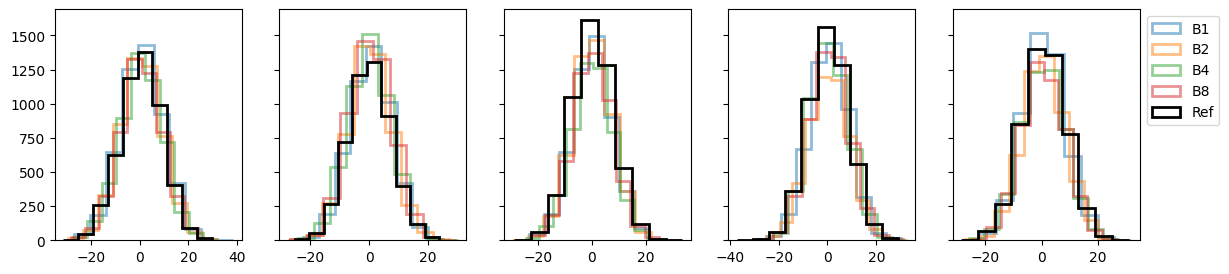

In [40]:
Dplot = min(5, D)
fig, ax = plt.subplots(1, Dplot, figsize=(14, 3), sharey=True)

# B = 8
# for lr in lrs:
#     hp = f"B{B}-lr{lr:0.3f}"
#     samples = np.random.multivariate_normal(res[hp]['mean'], res[hp]['cov'], 5000)
#     for i in range(Dplot):
#         ax[i].hist(samples[:, i], alpha=0.5, label=hp)
                
for ib, b in enumerate(Bs):
    hp = f"B{b}"
    samples = np.random.multivariate_normal(res[hp]['mean'], res[hp]['cov'], 5000)
    for i in range(Dplot):
        ax[i].hist(samples[:, i], alpha=0.5, label=f'B{b}', lw=2, histtype='step', color=f'C{ib}')
        
for i in range(Dplot):
    ax[i].hist(ref_samples[:, i], alpha=1.0, label='Ref', lw=2, histtype='step', color='k')
    
ax[-1].legend(bbox_to_anchor=(1, 1))


/tmp/ipykernel_1350733/2248962390.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(-1, res[hp]['bkl'][0]*1.2)


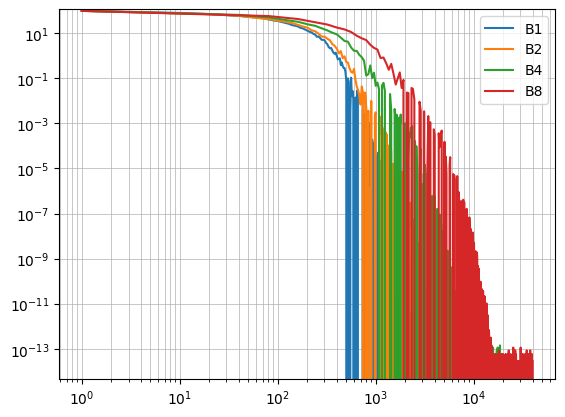

In [41]:
# B = 16
# for i, lr in enumerate(lrs):
#     hp = f"B{B}-lr{lr:0.3f}"
#     plt.plot(res[hp]['nevals'], res[hp]['bkl'], f'C{i}', label=hp)
#     plt.plot(res2[hp]['nevals'], res2[hp]['bkl'], f'C{i}--', lw=1.)
    
for B in Bs:
    plt.plot(res[f"B{B}"]['nevals'], res[f"B{B}"]['bkl'], '-', label=f'B{B}')
    # plt.plot(res[f"B{B}"]['nevals'], res[f"B{B}"]['fkl'], '-', label=f'B{B}')

plt.loglog()
plt.semilogx()

plt.ylim(-1, res[hp]['bkl'][0]*1.2)
plt.grid(which='both', lw=0.5)
plt.legend()

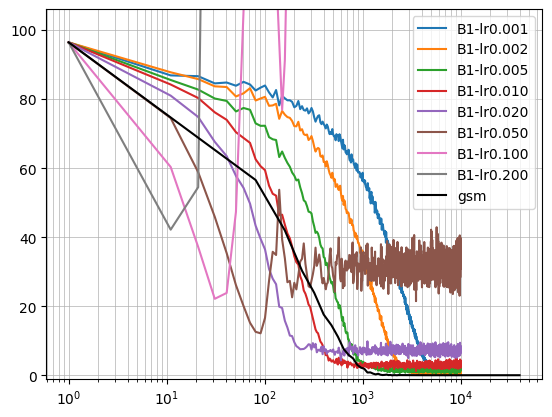

In [42]:
B = 1
for i, lr in enumerate(lrs):
    hp = f"B{B}-lr{lr:0.3f}"
    plt.plot(res[hp]['nevals'], res[hp]['bkl'], f'C{i}', label=hp)
    # plt.plot(res2[hp]['nevals'], res2[hp]['bkl'], f'C{i}--', lw=1.)
    
B=8
plt.plot(res[f"B{B}"]['nevals'], res[f"B{B}"]['bkl'], 'k-', label='gsm')

# plt.loglog()
plt.semilogx()
plt.ylim(-1, res[hp]['bkl'][0]*1.1)
plt.grid(which='both', lw=0.5)
plt.legend()

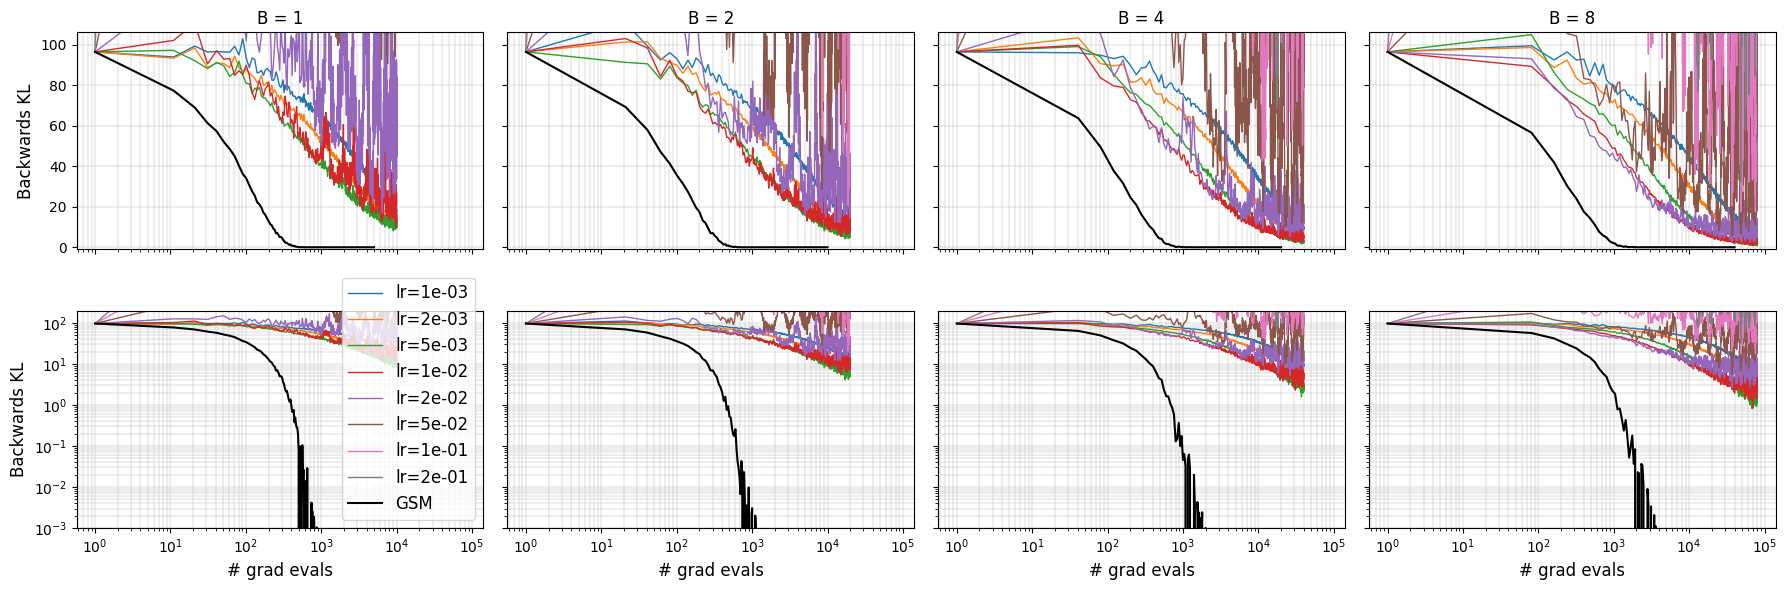

In [43]:
fig, ax = plt.subplots(2, 4, figsize=(18, 6), sharex=True, sharey="row")

Bg = 1
for ib, B in enumerate(Bs[:4]):
    axis = ax.flatten()[ib]
    for i, lr in enumerate(lrs):
        hp = f"B{B}-lr{lr:0.3f}"
        # axis.plot(res[hp]['nevals'], res[hp]['bkl'], f'C{i}', label=f"lr={hp.split('-')[1][2:]}")
        axis.plot(res2[hp]['nevals'], res2[hp]['bkl'], f'C{i}-', lw=1)
    
    Bg = B
    axis.plot(res[f"B{Bg}"]['nevals'], res[f"B{Bg}"]['bkl'], 'k-', label='gsm', alpha=1)
    plt.semilogx()
    axis.set_ylim(-1, res[f"B{Bg}"]['bkl'][0]*1.1)
    axis.grid(which='both', lw=0.3)
    axis.set_title(f"B = {B}")

    
for ib, B in enumerate(Bs[:4]):
    axis = ax.flatten()[ib+4]
    for i, lr in enumerate(lrs):
        hp = f"B{B}-lr{lr:0.3f}"
        # axis.plot(res[hp]['nevals'], res[hp]['bkl'], f'C{i}')
        axis.plot(res2[hp]['nevals'], res2[hp]['bkl'], f'C{i}-', lw=1., label=f"lr={float(hp.split('-')[1][2:]):0.0e}")
        
    Bg = B
    axis.plot(res[f"B{Bg}"]['nevals'], res[f"B{Bg}"]['bkl'], 'k-', label='GSM')

    plt.loglog()
    axis.set_ylim(1e-3, res[f"B{Bg}"]['bkl'][0]*2)
    axis.grid(which='both', lw=0.3)

ax[1, 0].legend(ncol=1, loc=4, fontsize=12)
    
for axis in ax[:, 0]:
    axis.set_ylabel("Backwards KL", fontsize=12)
for axis in ax[1]:
    axis.set_xlabel("# grad evals", fontsize=12)
    
plt.tight_layout()

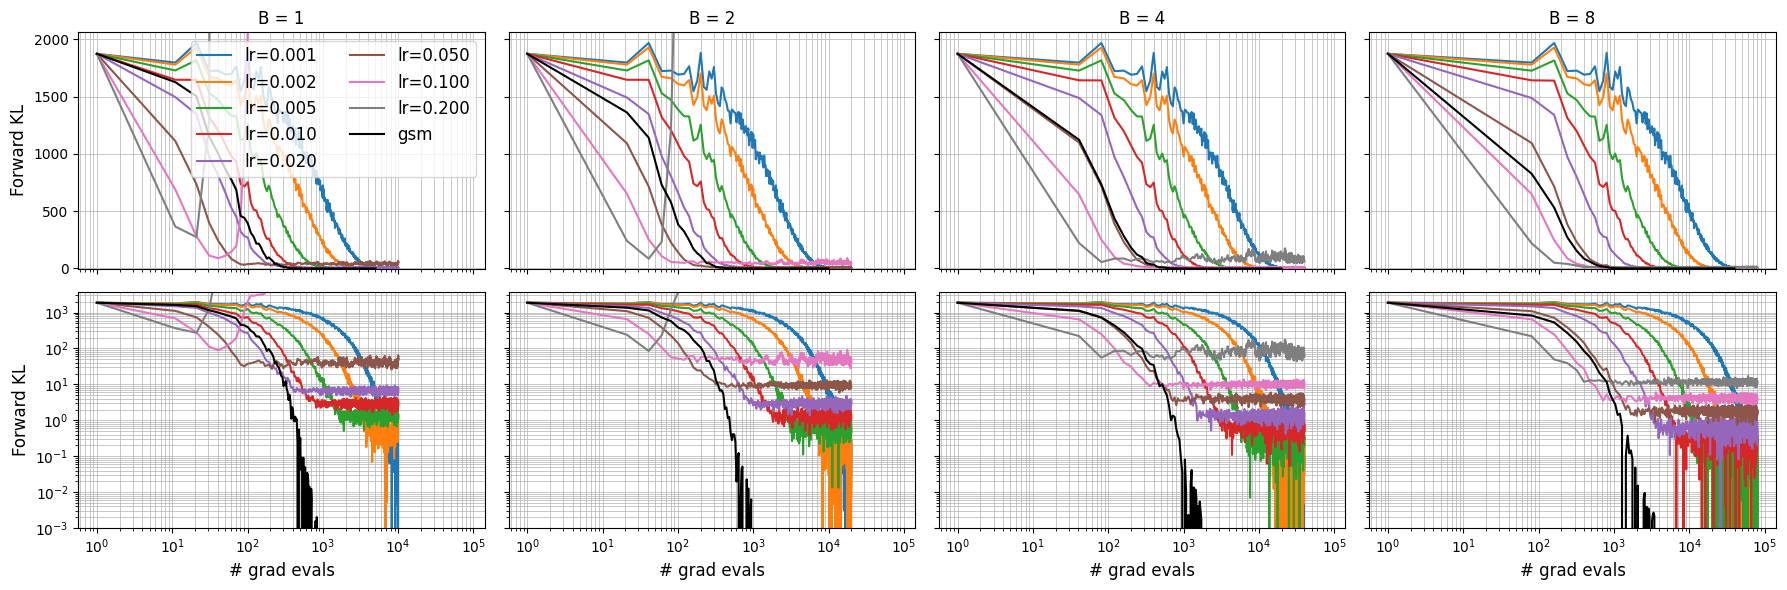

In [44]:
fig, ax = plt.subplots(2, 4, figsize=(18, 6), sharex=True, sharey="row")

Bg = 1
mode='fkl'

for ib, B in enumerate(Bs[:4]):
    axis = ax.flatten()[ib]
    for i, lr in enumerate(lrs):
        hp = f"B{B}-lr{lr:0.3f}"
        axis.plot(res[hp]['nevals'], res[hp][mode], f'C{i}', label=f"lr={hp.split('-')[1][2:]}")
        # axis.plot(res2[hp]['nevals'], res2[hp][mode], f'C{i}-', lw=1., label=f"lr={hp.split('-')[1][2:]}")
        
    Bg = B
    axis.plot(res[f"B{Bg}"]['nevals'], res[f"B{Bg}"][mode], 'k-', label='gsm')
    plt.semilogx()
    axis.set_ylim(-1, res[f"B{Bg}"][mode][0]*1.1)
    axis.grid(which='both', lw=0.5)
    axis.set_title(f"B = {B}")

    
for ib, B in enumerate(Bs[:4]):
    axis = ax.flatten()[ib+4]
    for i, lr in enumerate(lrs):
        hp = f"B{B}-lr{lr:0.3f}"
        axis.plot(res[hp]['nevals'], res[hp][mode], f'C{i}')
        # axis.plot(res2[hp]['nevals'], res2[hp][mode], f'C{i}-', lw=1.)
        
    Bg = B
    axis.plot(res[f"B{Bg}"]['nevals'], res[f"B{Bg}"][mode], 'k-', label='gsm')

    plt.loglog()
    axis.set_ylim(1e-3, res[f"B{Bg}"][mode][0]*2)
    axis.grid(which='both', lw=0.5)

ax[0, 0].legend(ncol=2, loc=1, fontsize=12)

    
for axis in ax[:, 0]:
    axis.set_ylabel("Forward KL", fontsize=12)
for axis in ax[1]:
    axis.set_xlabel("# grad evals", fontsize=12)
    
plt.tight_layout()

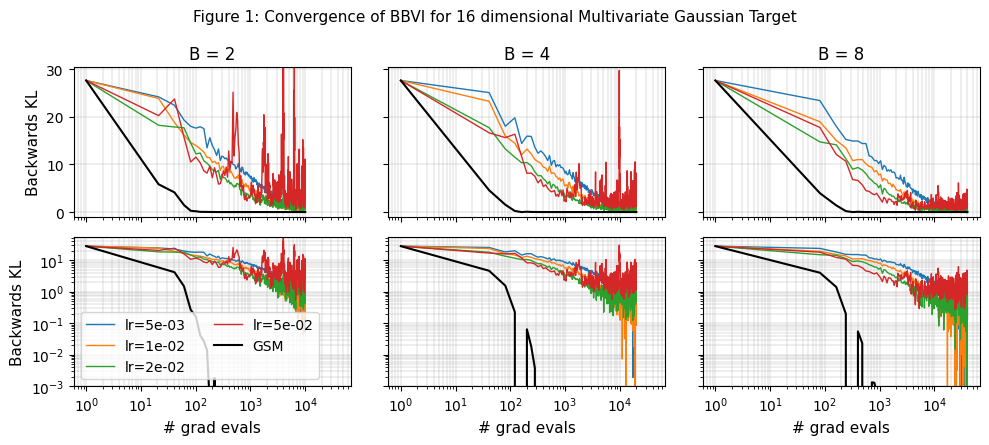

In [53]:
# # Save figure for BBVI

fig, ax = plt.subplots(2, 3, figsize=(10, 4.5), sharex=True, sharey="row")

Bg = 1
for ib, B in enumerate(Bs[1:4]):
    axis = ax.flatten()[ib]
    for i, lr in enumerate(lrs):
        hp = f"B{B}-lr{lr:0.3f}"
        # axis.plot(res[hp]['nevals'], res[hp]['bkl'], f'C{i}', label=f"lr={float(hp.split('-')[1][2:]):0.0e}")
        axis.plot(res2[hp]['nevals'], res2[hp]['bkl'], f'C{i}-', lw=1)
    
    Bg = B
    axis.plot(res[f"B{Bg}"]['nevals'], res[f"B{Bg}"]['bkl'], 'k-', label='GSM', alpha=1)
    plt.semilogx()
    axis.set_ylim(-1, res[f"B{Bg}"]['bkl'][0]*1.1)
    axis.grid(which='both', lw=0.3)
    axis.set_title(f"B = {B}")

    
for ib, B in enumerate(Bs[1:4]):
    axis = ax.flatten()[ib+ax.shape[1]]
    for i, lr in enumerate(lrs):
        hp = f"B{B}-lr{lr:0.3f}"
        # axis.plot(res[hp]['nevals'], res[hp]['bkl'], f'C{i}', label=f"lr={float(hp.split('-')[1][2:]):0.0e}")
        axis.plot(res2[hp]['nevals'], res2[hp]['bkl'], f'C{i}-', lw=1., label=f"lr={float(hp.split('-')[1][2:]):0.0e}")
        
    Bg = B
    axis.plot(res[f"B{Bg}"]['nevals'], res[f"B{Bg}"]['bkl'], 'k-', label='GSM')

    plt.loglog()
    axis.set_ylim(1e-3, res[f"B{Bg}"]['bkl'][0]*2)
    axis.grid(which='both', lw=0.3)

ax[1, 0].legend(ncol=2, loc=3, fontsize=10)
# ax[0, -1].legend(ncol=1, fontsize=11, bbox_to_anchor=(1, 1))
    
for axis in ax[:, 0]:
    axis.set_ylabel("Backwards KL", fontsize=11)
for axis in ax[1]:
    axis.set_xlabel("# grad evals", fontsize=11)
    
plt.suptitle(f"Figure 1: Convergence of BBVI for {D} dimensional Multivariate Gaussian Target", fontsize=11)
plt.tight_layout()
# plt.savefig(f'/mnt/ceph/users/cmodi/polyakVI/gsmpaper_rebuttal/FRG/D{D}/advi/bkl.png')
# plt.savefig(f'/mnt/ceph/users/cmodi/polyakVI/gsmpaper_rebuttal/FRG/D{D}/advi/bkl.pdf')

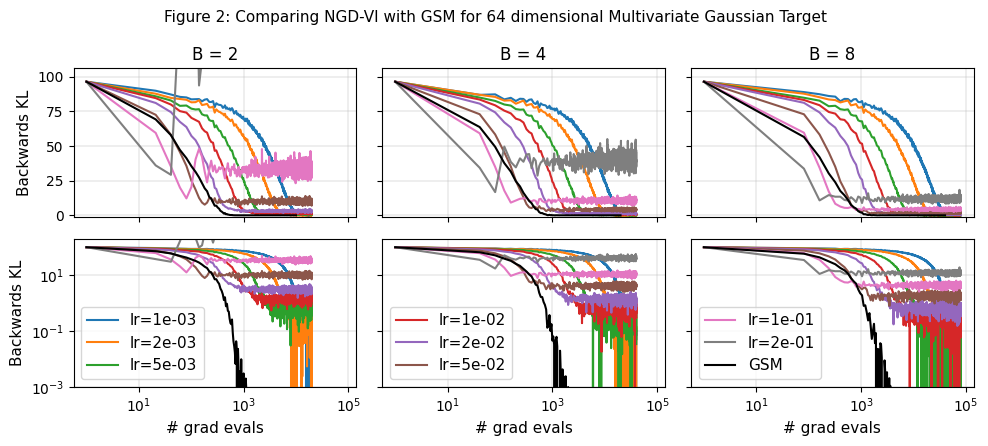

In [49]:
# # Save figure for NGD

# fig, ax = plt.subplots(2, 3, figsize=(10, 4.5), sharex=True, sharey="row")

# Bg = 1
# # for ib, B in enumerate(Bs[:3]):
# for ib, B in enumerate(Bs[1:4]):
#     axis = ax.flatten()[ib]
#     for i, lr in enumerate(lrs):
#         hp = f"B{B}-lr{lr:0.3f}"
#         axis.plot(res[hp]['nevals'], res[hp]['bkl'], f'C{i}', label=f"lr={float(hp.split('-')[1][2:]):0.0e}")
    
#     Bg = B
#     axis.plot(res[f"B{Bg}"]['nevals'], res[f"B{Bg}"]['bkl'], 'k-', label='GSM', alpha=1)
#     plt.semilogx()
#     axis.set_ylim(-1, res[f"B{Bg}"]['bkl'][0]*1.1)
#     axis.grid(which='both', lw=0.3)
#     axis.set_title(f"B = {B}")

    
# # for ib, B in enumerate(Bs[:3]):
# for ib, B in enumerate(Bs[1:4]):
#     axis = ax.flatten()[ib+ax.shape[1]]
#     for i, lr in enumerate(lrs):
#         hp = f"B{B}-lr{lr:0.3f}"
#         lbl = None
#         if i//ax.shape[1] == ib: lbl = f"lr={float(hp.split('-')[1][2:]):0.0e}"
#         axis.plot(res[hp]['nevals'], res[hp]['bkl'], f'C{i}', label=lbl)
        
#     Bg = B
#     lbl = None
#     if ib == ax.shape[1]-1: lbl = "GSM"
#     axis.plot(res[f"B{Bg}"]['nevals'], res[f"B{Bg}"]['bkl'], 'k-', label=lbl)

#     plt.loglog()
#     axis.set_ylim(1e-3, res[f"B{Bg}"]['bkl'][0]*2)
#     axis.grid(which='both', lw=0.3)

# # ax[1, 0].legend(ncol=2, loc=4, fontsize=11)
# # ax[1, -1].legend(ncol=1, fontsize=11, loc='lower left')
    
# for axis in ax[:, 0]:
#     axis.set_ylabel("Backwards KL", fontsize=11)
# for axis in ax[1]:
#     axis.legend(ncol=1, fontsize=11, loc='lower left')
#     axis.set_xlabel("# grad evals", fontsize=11)
    
# plt.suptitle(f"Figure 2: Comparing NGD-VI with GSM for {D} dimensional Multivariate Gaussian Target", fontsize=11)
# plt.tight_layout()
# # plt.savefig(f'/mnt/ceph/users/cmodi/polyakVI/gsmpaper_rebuttal/FRG/D{D}/ngd/bkl.png')
# # plt.savefig(f'/mnt/ceph/users/cmodi/polyakVI/gsmpaper_rebuttal/FRG/D{D}/ngd/bkl.pdf')

In [288]:
np.load('/mnt/ceph/users/cmodi/polyakVI/gsmpaper/PDB_11/samples.npy').shape

(10000, 8)

In [290]:
np.load('/mnt/ceph/users/cmodi/polyakVI/gsmpaper/PDB_11/gsm-frg/B02/S1/samples.npy').shape

(1000, 8)

# timing

In [7]:
D

2048

In [8]:
from functools import partial

@jit
def _gsm_update_single(sample, v, mu0, S0):
    '''returns GSM update to mean and covariance matrix for a single sample                                                                                                                   
    '''
    S0v = jnp.matmul(S0, v)
    vSv = jnp.matmul(v, S0v)
    mu_v = jnp.matmul((mu0 - sample), v)
    rho = 0.5 * jnp.sqrt(1 + 4*(vSv + mu_v**2)) - 0.5
    eps0 = S0v - mu0 + sample

    #mu update                                                                                                                                                                                
    mu_vT = jnp.outer((mu0 - sample), v)
    den = 1 + rho + mu_v
    I = jnp.eye(sample.shape[0])
    mu_update = 1/(1 + rho) * jnp.matmul(( I - mu_vT / den), eps0)
    mu = mu0 + mu_update

    #S update                                                                                                                                                                                 
    Supdate_0 =  jnp.outer((mu0-sample), (mu0-sample))
    Supdate_1 =  jnp.outer((mu-sample), (mu-sample))
    S_update = (Supdate_0 - Supdate_1)
    return mu_update, S_update


vgsm_update = jax.vmap(_gsm_update_single, in_axes=(0, 0, None, None))

@partial(jit, static_argnums=(0))
def gsm_update(lp_g, key, mu0, S0):
    """                                                                                                                                                                                       
    Returns updated mean and covariance matrix with GSM updates.                                                                                                                              
    For a batch, this is simply the mean of updates for individual samples.                                                                                                                   
                                                                                                                                                                                              
    Inputs:                                                                                                                                                                                   
      samples: Array of samples of shape BxD where B is the batch dimension                                                                                                                   
      vs : Array of score functions of shape BxD corresponding to samples                                                                                                                     
      mu0 : Array of shape D, current estimate of the mean                                                                                                                                    
      S0 : Array of shape DxD, current estimate of the covariance matrix                                                                                                                      
                                                                                                                                                                                              
    Returns:                                                                                                                                                                                  
      mu : Array of shape D, new estimate of the mean                                                                                                                                         
      S : Array of shape DxD, new estimate of the covariance matrix                                                                                                                           
    """

    # Can generate samples from jax distribution (commented below), but using numpy is faster                                                                                         
    key, key_sample = random.split(key, 2)
    q = MultivariateNormal(loc=mu0, covariance_matrix=S0)
    #                                                                                                                                                                                     
    samples = q.sample(key, (1,))
    vs = lp_g(samples)
    mu_update, S_update = vgsm_update(samples, vs, mu0, S0)
    mu_update = jnp.mean(mu_update, axis=0)
    S_update = jnp.mean(S_update, axis=0)
    mu = mu0 + mu_update
    S = S0 + S_update

    return mu, S


key = random.PRNGKey(0)
mu0, cov0 = np.zeros(D), np.eye(D)
gsm_update(lp_g, key, mu0, cov0);

In [9]:
%timeit gsm_update(lp_g, key, mu0, cov0)

233 ms ± 946 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
idx_tril = jnp.stack(jnp.tril_indices(D)).T

def neg_elbo(params, key):
    """                                                                                                                                                                                   
    Internal function to evaluate negative-ELBO which is the loss function                                                                                                                
    """
    loc, scales = params
    scale_tril = jnp.zeros((D, D))
    scale_tril = scale_tril.at[idx_tril[:, 0], idx_tril[:, 1]].set(scales)
    q = MultivariateNormal(loc=loc, scale_tril=scale_tril)
    #                                                                                                                                                                                     
    key, key_sample = random.split(key, 2)
    samples = q.sample(key, (1,))
    logl = jnp.sum(lp(samples))
    logq = jnp.sum(q.log_prob(samples))
    elbo = logl - logq
    negelbo = -1. * elbo
    return negelbo

# lossf = jit(neg_elbo, static_argnums=(1))

@jit
def opt_step(params, opt_state, key):
    loss, grads = jax.value_and_grad(neg_elbo, argnums=0)( params, key)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

L = np.linalg.cholesky(cov0)
scales = jnp.array(L[np.tril_indices(D)])
params = (mu0, scales)
opt = optax.adam(learning_rate=1e-2)
opt_state = opt.init(params)
params, opt_state, loss = opt_step(params, opt_state, key)

In [11]:
%timeit opt_step(params, opt_state, key)

227 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# GMM VI

In [8]:
from gmmvi.gmmvi_runner import GmmviRunner
from gmmvi.configs import get_default_algorithm_config, update_config

def run_gmmvi(batch, model, x0, modelpath, callback, samples):
    '''This function is based on the following example https://gmmvi.readthedocs.io/en/latest/get_started.html#using-the-gmmvirunner-with-custom-environments
    '''

# For creating a custom environment, we need to extend
# gmmvi.experiments.target_distributions.lnpdf.LNPDF:
    from gmmvi.experiments.target_distributions.lnpdf import LNPDF
    class Target(LNPDF):
        def __init__(self):
            super(Target, self).__init__(safe_for_tf_graph=False)
            self.model = model

        def get_num_dimensions(self) -> int:
            return self.model.d

        def log_density(self, samples: tf.Tensor) -> tf.Tensor:
            return self.model.log_prob(samples)


    # We can also use the GmmviRunner, when using custom environments, but we have
    # to put the LNPDF object into the dict. Furthermore, we need to define the other
    # environment-specific settings that would otherwise be defined in
    # the corresponding config in gmmvi/config/experiment_configs:
    environment_config = {
        "target_fn": None, ## I somehow couldn't add Target() here, but I had to add it after merge_configs()
        "start_seed": 0,
        "environment_name": "GSMTARGET",
        "model_initialization": {
            "use_diagonal_covs": False,
            "num_initial_components": 1,
            # Does GSM/BBVI use the same initial Gaussian???
            "prior_mean": 0., 
            "prior_scale": 1.,
            "initial_cov": 1.,
        },
        "gmmvi_runner_config": {
            "log_metrics_interval": 1
        },
        "use_sample_database": True,
        "max_database_size": int(1e6),
        "temperature": 1.
    }

    algorithm_config = get_default_algorithm_config("SEMTRON") # The recommended variant is SAMTRON, SEMTRON does not add additional components
    algorithm_config['sample_selector_config']['desired_samples_per_component']= batch # Only hyperparameter worth tuning?

    # Now we just need to merge the configs and use GmmviRunner as before:
    merged_config = update_config(algorithm_config, environment_config)
    merged_config['target_fn']=Target()
    gmmvi_runner = GmmviRunner.build_from_config(merged_config)

    for epoch in range(100):
        gmmvi_runner.iterate_and_log(epoch)

    return None, None, None, None

In [9]:
import tensorflow as tf

In [10]:
# from gmmvi.gmmvi_runner import GmmviRunner
# from gmmvi.configs import get_default_algorithm_config, update_config

# batch = 8

# from gmmvi.experiments.target_distributions.lnpdf import LNPDF

# class Target(LNPDF):
#     def __init__(self):
#         super(Target, self).__init__(safe_for_tf_graph=False)
#         self.model = model

#     def get_num_dimensions(self) :
#         return D

#     def log_density(self, samples):
#         return tf.constant(self.model.log_prob(samples))


# # We can also use the GmmviRunner, when using custom environments, but we have
# # to put the LNPDF object into the dict. Furthermore, we need to define the other
# # environment-specific settings that would otherwise be defined in
# # the corresponding config in gmmvi/config/experiment_configs:
# environment_config = {
#     "target_fn": None, ## I somehow couldn't add Target() here, but I had to add it after merge_configs()
#     "start_seed": 0,
#     "environment_name": "GSMTARGET",
#     "model_initialization": {
#         "use_diagonal_covs": False,
#         "num_initial_components": 1,
#         # Does GSM/BBVI use the same initial Gaussian???
#         "prior_mean": 0., 
#         "prior_scale": 1.,
#         "initial_cov": 1.,
#     },
#     "gmmvi_runner_config": {
#         "log_metrics_interval": 1
#     },
#     "use_sample_database": True,
#     "max_database_size": int(1e6),
#     "temperature": 1.
# }

# algorithm_config = get_default_algorithm_config("SEMTRON") # The recommended variant is SAMTRON, SEMTRON does not add additional components
# algorithm_config['sample_selector_config']['desired_samples_per_component']= batch # Only hyperparameter worth tuning?

# # Now we just need to merge the configs and use GmmviRunner as before:
# merged_config = update_config(algorithm_config, environment_config)
# merged_config['target_fn']=Target()
# gmmvi_runner = GmmviRunner.build_from_config(merged_config)

# for epoch in range(10):
#     gmmvi_runner.iterate_and_log(epoch)



In [72]:
D = 256
r = 256
# D = 20
# r = 4
path = f'/mnt/home/cmodi/Research/Projects/GSM-VI/submitted-version/scripts_submitted/tmp/FRG/d{D}-r{r}-n1.00e-02/'

mean = np.load(f'{path}/mean.npy')
assert mean.size == D
cov = np.load(f'{path}/cov.npy')
ref_samples = np.load(f'{path}/samples.npy')
model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
lp = jit(lambda x: jnp.sum(model.log_prob(x)))
lp_g = jit(grad(lp, argnums=0))

niter = 2000
key = jax.random.PRNGKey(0)

In [73]:

params = {}
alg = "gsm"
monitorg = Monitor(batch_size=64, ref_samples=ref_samples)
params[alg] = gsm_fit(D, lp, lp_g, monitor=monitorg, niter=niter, batch_size=2)


Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000
Iteration 2000 of 2000


In [42]:

# alg = "gsm-B8"
# monitorg8 = Monitor(batch_size=64, ref_samples=ref_samples)
# params[alg] = gsm_fit(D, lp, lp_g, monitor=monitorg8, niter=niter, batch_size=8)


Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000
Iteration 2000 of 2000


In [74]:

alg = "gsm-B1"
monitorg1 = Monitor(batch_size=64, ref_samples=ref_samples)
params[alg] = gsm_fit(D, lp, lp_g, monitor=monitorg1, niter=niter, batch_size=1)


Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000
Iteration 2000 of 2000


In [ ]:
# # NGD
# key = random.PRNGKey(0)
# mean_fit, cov_fit = np.zeros(D), np.eye(D)*1.0
# monitorv = Monitor(batch_size=64, ref_samples=ref_samples)
# monitorv(0, [mean_fit, cov_fit], lp, key, nevals=1)

# batch_ngd = 2
# lr = 5e-2
# reg = 1e-8
# losses = []
# for i in range(niter+1):
#     if i%100 == 0 :print(i)
#     l, mean_new, cov_new = ngd_update(lp, lp_g, mean_fit, cov_fit, lr=lr, batch=batch_ngd, reg=reg)
#     mean_fit, cov_fit = check_cov(i, mean_new, cov_new, mean_fit, cov_fit)
#     key, key_sample = random.split(key, 2)
#     monitorv(i, [mean_fit, cov_fit], lp, key, nevals=batch_ngd)
#     losses.append(l)
    

In [75]:


# batch = 1
# # timestamp = "1692222627.0414882"
# dirname = '/mnt/home/cmodi/Research/Projects/GSM-VI/submitted-version/scripts_submitted/tmp/FRG/d4-r4-n1.00e-02/NGD-B1/1692223207.9410677/'
# mus, covs = [], []
# for i in range(niter):
#     p = np.load(f'{dirname}/gmm_dump_{i}.npz')
#     mus.append(p['means'])
#     covs.append(p['covs'])


# key = random.PRNGKey(0)

# monitorn = Monitor(batch_size=32, ref_samples=ref_samples)
# mean_fit, cov_fit = np.zeros(D), np.eye(D)*1.0
# monitorn(0, [mean_fit, cov_fit], lp, key, nevals=1)
# losses = []
# for i in range(niter):
#     mean_fit, cov_fit = mus[i][0], covs[i][0]
#     monitorn(i, [mean_fit, cov_fit], lp, key, nevals=batch)
    
# params['ngd'] =  [mean_fit, cov_fit]


In [75]:
def insert_sweep_name(path):
    dirname = path
    print(f"In directory {dirname}")
    for root, dirs, files in os.walk(dirname):
        if len(dirs) > 1 :
            print('More than 1 sweeps, abort!')
            raise
        break
    print(f"Timestamp : {dirs[0]}")
    if '%s' in path:
        return path%dirs[0]
    else:
        return path + f'/{dirs[0]}/'


ngd = {}

# bbs = [1, 2, 4, 8, 15, 20, 30]
bbs = [100, 150, 200, 300]
for b in bbs:
    dirname = insert_sweep_name(path + f'/NGD-B{b}')
    mus, covs = [], []
    for i in range(500):
        p = np.load(f'{dirname}/gmm_dump_{i}.npz')
        mus.append(p['means'])
        covs.append(p['covs'])
    key = random.PRNGKey(0)

    monitorn = Monitor(batch_size=64, ref_samples=ref_samples)

    mean_fit, cov_fit = np.zeros(D), np.eye(D)*1.0
    monitorn(0, [mean_fit, cov_fit], lp, key, nevals=1)
    for i in range(len(mus)):
        mean_fit, cov_fit = mus[i][0], covs[i][0]
        monitorn(i, [mean_fit, cov_fit], lp, key, nevals=b)

    ngd[b] = [mus, covs, monitorn]    
    params[f'ngd{b}'] =  [mean_fit, cov_fit]


In directory /mnt/home/cmodi/Research/Projects/GSM-VI/submitted-version/scripts_submitted/tmp/FRG/d256-r256-n1.00e-02//NGD-B100
Timestamp : 1692395103.4950006
In directory /mnt/home/cmodi/Research/Projects/GSM-VI/submitted-version/scripts_submitted/tmp/FRG/d256-r256-n1.00e-02//NGD-B150
Timestamp : 1692458773.9086502
In directory /mnt/home/cmodi/Research/Projects/GSM-VI/submitted-version/scripts_submitted/tmp/FRG/d256-r256-n1.00e-02//NGD-B200
Timestamp : 1692395263.5287268
In directory /mnt/home/cmodi/Research/Projects/GSM-VI/submitted-version/scripts_submitted/tmp/FRG/d256-r256-n1.00e-02//NGD-B300
Timestamp : 1692395409.23148


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


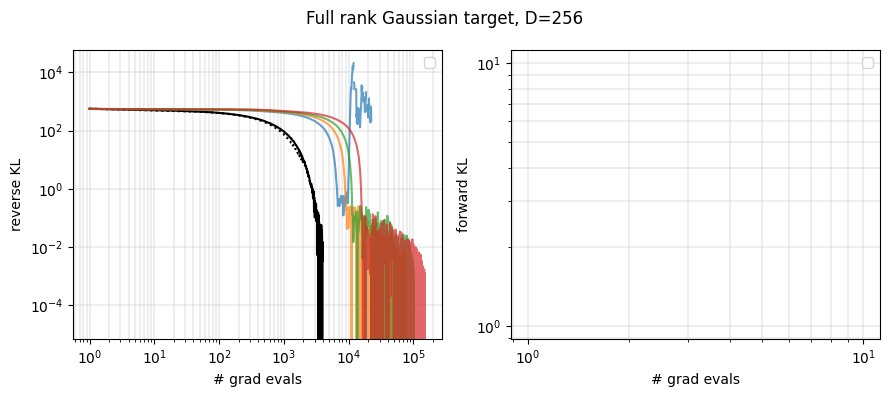

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

ax[0].plot(monitorg.nevals, monitorg.bkl, 'k', label='', lw=1.5)
# ax[0].plot(monitorg8.nevals, monitorg8.bkl, 'k--', label='', lw=1.5)
ax[0].plot(monitorg1.nevals, monitorg1.bkl, 'k:', label='', lw=1.5)
# ax[0].plot(monitorv.nevals, monitorv.bkl, 'k--', label='', lw=1.5)

for b in bbs:
    m = ngd[b][-1]
    ax[0].plot(m.nevals, m.bkl, label='', alpha=0.7)

# ax[1].plot(monitorg.nevals, monitorg.fkl, 'k', label='GSM-B2', lw=1.5)
# # ax[1].plot(monitorv.nevals, monitorv.fkl, 'k--', label='VOGN-B2', lw=1.5)
# for b in [1, 2, 4, 8, 30]:
#     m = ngd[b][-1]
#     ax[1].plot(m.nevals, m.fkl, label=f'NGD-B{b}', alpha=0.7)

for axis in ax:
    axis.semilogy()
    axis.legend()
    axis.semilogx()
    axis.set_xlabel('# grad evals')
    axis.grid(which='both', lw=0.3)
ax[0].set_ylabel('reverse KL')
ax[1].set_ylabel('forward KL')
plt.suptitle(f"Full rank Gaussian target, D={D}")
plt.tight_layout()


In [83]:
np.array(monitorg.nevals)[np.where(np.array(monitorg.bkl) < 1e-2)][0]

3301

In [84]:
# for b in [100, 200, 300]:
for b in bbs:
    m = ngd[b][-1]
    try:
        print(b, np.array(m.nevals)[np.where(np.array(m.bkl) < 1e-2)][0])
    except Exception as e:
        print(e)
        print(f'{b} failed')

index 0 is out of bounds for axis 0 with size 0
100 failed
150 11101
200 13601
300 16801


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

ax[0].plot(monitorg.nevals, monitorg.bkl, 'k', label='', lw=1.5)
ax[0].plot(monitorv.nevals, monitorv.bkl, 'k--', label='', lw=1.5)
# for b in [1, 2, 4, 8, 30]:
for b in [30, 100]:
    m = ngd[b][-1]
    ax[0].plot(m.nevals, m.bkl, label='', alpha=0.7)

# ax[1].plot(monitorg.nevals, monitorg.fkl, 'k', label='GSM-B2', lw=1.5)
# # ax[1].plot(monitorv.nevals, monitorv.fkl, 'k--', label='VOGN-B2', lw=1.5)
# for b in [1, 2, 4, 8, 30]:
#     m = ngd[b][-1]
#     ax[1].plot(m.nevals, m.fkl, label=f'NGD-B{b}', alpha=0.7)

for axis in ax:
    axis.semilogy()
    axis.legend()
    axis.semilogx()
    axis.set_xlabel('# grad evals')
    axis.grid(which='both', lw=0.3)
ax[0].set_ylabel('reverse KL')
ax[1].set_ylabel('forward KL')
plt.suptitle(f"Full rank Gaussian target, D={D}")
plt.tight_layout()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


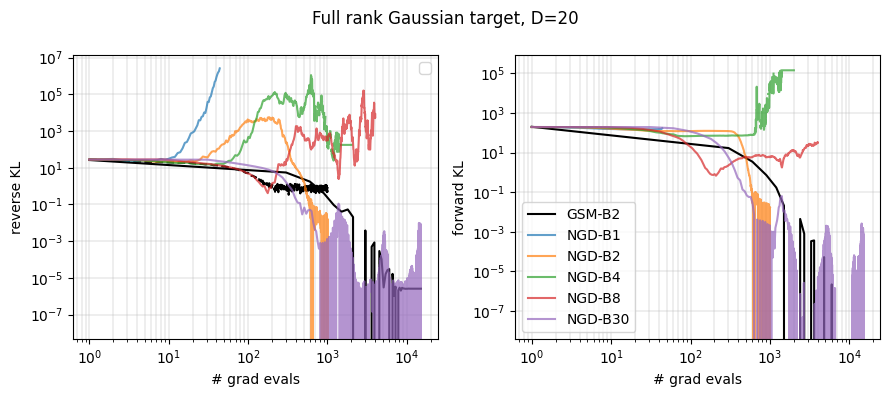

In [69]:
# fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# ax[0].plot(monitorg.nevals, monitorg.bkl, 'k', label='', lw=1.5)
# ax[0].plot(monitorv.nevals, monitorv.bkl, 'k--', label='', lw=1.5)
# for b in [1, 2, 4, 8, 30]:
#     m = ngd[b][-1]
#     ax[0].plot(m.nevals, m.bkl, label='', alpha=0.7)

# ax[1].plot(monitorg.nevals, monitorg.fkl, 'k', label='GSM-B2', lw=1.5)
# # ax[1].plot(monitorv.nevals, monitorv.fkl, 'k--', label='VOGN-B2', lw=1.5)
# for b in [1, 2, 4, 8, 30]:
#     m = ngd[b][-1]
#     ax[1].plot(m.nevals, m.fkl, label=f'NGD-B{b}', alpha=0.7)

# for axis in ax:
#     axis.semilogy()
#     axis.legend()
#     axis.semilogx()
#     axis.set_xlabel('# grad evals')
#     axis.grid(which='both', lw=0.3)
# ax[0].set_ylabel('reverse KL')
# ax[1].set_ylabel('forward KL')
# plt.suptitle(f"Full rank Gaussian target, D={D}")
# plt.tight_layout()


In [336]:
batch_ngd = 1
lr_ngd = 5e-2
reg_ngd = 1e-8


In [352]:
def fit_ngd(D, lp, lp_g, monitor=None, niter=500, lr=5e-2, batch_size=1, reg=1e-8):
    
    key = random.PRNGKey(0)
    mean_fit, cov_fit = np.zeros(D), np.eye(D)*1.0
    if monitor is not None:
        monitor(0, [mean_fit, cov_fit], lp, key, nevals=1)
        
    for i in range(niter+1):
        if i%100 == 0 :print(i)
        l, mean_new, cov_new = ngd_update(lp, lp_g, mean_fit, cov_fit, lr=lr, batch=batch_size, reg=reg)
        mean_fit, cov_fit = check_cov(i, mean_new, cov_new, mean_fit, cov_fit)
        if monitor is not None:
            key, key_sample = random.split(key, 2)
            monitorv(i, [mean_fit, cov_fit], lp, key, nevals=batch_ngd)
    return mean_fit, cov_fit

Iteration 0 of 500
Iteration 50 of 500
Iteration 100 of 500
Iteration 150 of 500
Iteration 200 of 500
Iteration 250 of 500
Iteration 300 of 500
Iteration 350 of 500
Iteration 400 of 500
Iteration 450 of 500
Iteration 500 of 500
0
100
200
300
400
500
In directory /mnt/home/cmodi/Research/Projects/GSM-VI/submitted-version/scripts_submitted/tmp/FRG/d4-r4-n1.00e-02//NGD-B1
Timestamp : 1692223207.9410677
In directory /mnt/home/cmodi/Research/Projects/GSM-VI/submitted-version/scripts_submitted/tmp/FRG/d4-r4-n1.00e-02//NGD-B2
Timestamp : 1692223244.6471786
In directory /mnt/home/cmodi/Research/Projects/GSM-VI/submitted-version/scripts_submitted/tmp/FRG/d4-r4-n1.00e-02//NGD-B4
Timestamp : 1692223283.211021
In directory /mnt/home/cmodi/Research/Projects/GSM-VI/submitted-version/scripts_submitted/tmp/FRG/d4-r4-n1.00e-02//NGD-B8
Timestamp : 1692223322.134261
Iteration 0 of 500
Iteration 50 of 500
Iteration 100 of 500
Iteration 150 of 500
Iteration 200 of 500
Iteration 250 of 500
Iteration 300 of 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


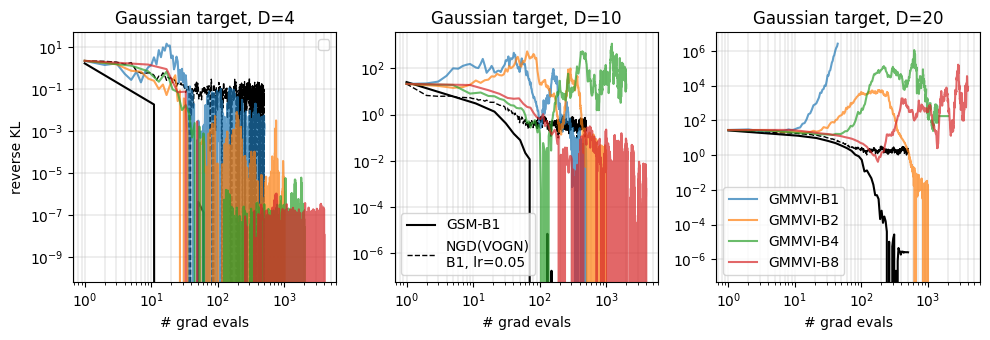

In [356]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3.5))

niter = 500
for ia, D in enumerate([4, 10, 20]):
# for ia, D in enumerate([4]):
    r = D
    path = f'/mnt/home/cmodi/Research/Projects/GSM-VI/submitted-version/scripts_submitted/tmp/FRG/d{D}-r{r}-n1.00e-02/'

    mean = np.load(f'{path}/mean.npy')
    assert mean.size == D
    cov = np.load(f'{path}/cov.npy')
    ref_samples = np.load(f'{path}/samples.npy')
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))

    params = {}
    alg = "gsm"
    monitorg = Monitor(batch_size=64, ref_samples=ref_samples)
    params[alg] = gsm_fit(D, lp, lp_g, monitor=monitorg, niter=niter, batch_size=1)
    
    monitorv = Monitor(batch_size=64, ref_samples=ref_samples)
    params['ngd'] = fit_ngd(D, lp, lp_g, monitor=monitorv, niter=niter, batch_size=1)
    

    ngd = {}
    for b in [1, 2, 4, 8]:
        dirname = insert_sweep_name(path + f'/NGD-B{b}')
        mus, covs = [], []
        for i in range(niter):
            p = np.load(f'{dirname}/gmm_dump_{i}.npz')
            mus.append(p['means'])
            covs.append(p['covs'])
            
        key = random.PRNGKey(0)
        monitorn = Monitor(batch_size=64, ref_samples=ref_samples)
        mean_fit, cov_fit = np.zeros(D), np.eye(D)*1.0
        monitorn(0, [mean_fit, cov_fit], lp, key, nevals=1)
        for i in range(niter):
            mean_fit, cov_fit = mus[i][0], covs[i][0]
            monitorn(i, [mean_fit, cov_fit], lp, key, nevals=b)

        ngd[b] = [mus, covs, monitorn]    
        params[f'ngd{b}'] =  [mean_fit, cov_fit]

    
    lbl = None
    if ia == 1:
        ax[ia].plot(monitorg.nevals, monitorg.bkl, 'k', label='GSM-B1', lw=1.5)
        ax[ia].plot(monitorv.nevals, monitorv.bkl, 'k--', label='NGD(VOGN)\nB1, lr=0.05', lw=1)
    else:
        ax[ia].plot(monitorg.nevals, monitorg.bkl, 'k', label='', lw=1.5)
        ax[ia].plot(monitorv.nevals, monitorv.bkl, 'k--', label='', lw=1)
        
    for b in [1, 2, 4, 8]:
        if ia == 2: lbl = f'GMMVI-B{b}'
        m = ngd[b][-1]
        ax[ia].plot(m.nevals, m.bkl, label=lbl, alpha=0.7)

    ax[ia].set_title(f"Gaussian target, D={D}")
    
for axis in ax:
    axis.semilogy()
    axis.legend()
    axis.semilogx()
    axis.set_xlabel('# grad evals')
    axis.grid(which='both', lw=0.3)
ax[0].set_ylabel('reverse KL')
plt.tight_layout()


In [1]:
monitorg.

SyntaxError: invalid syntax (1666704647.py, line 1)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3.5))

niter = 500
for ia, D in enumerate([4, 10, 20]):
    r = D
    path = f'/mnt/home/cmodi/Research/Projects/GSM-VI/submitted-version/scripts_submitted/tmp/FRG/d{D}-r{r}-n1.00e-02/'

    mean = np.load(f'{path}/mean.npy')
    assert mean.size == D
    cov = np.load(f'{path}/cov.npy')
    ref_samples = np.load(f'{path}/samples.npy')
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))

    params = {}
    alg = "gsm"
    monitorg = Monitor(batch_size=64, ref_samples=ref_samples)
    params[alg] = gsm_fit(D, lp, lp_g, monitor=monitorg, niter=niter, batch_size=1)
    
    
    mean_fit, cov_fit = np.zeros(D), np.eye(D)*1.0
    monitorv = Monitor(batch_size=64, ref_samples=ref_samples)
    monitorv(0, [mean_fit, cov_fit], lp, key, nevals=1)
    for i in range(niter+1):
        if i%100 == 0 :print(i)
        l, mean_new, cov_new = ngd_update(lp, lp_g, mean_fit, cov_fit, lr=lr_ngd, batch=batch_ngd, reg=reg_ngd)
        mean_fit, cov_fit = check_cov(i, mean_new, cov_new, mean_fit, cov_fit)
        key, key_sample = random.split(key, 2)
        monitorv(i, [mean_fit, cov_fit], lp, key, nevals=batch_ngd)

    ngd = {}
    for b in [1, 2, 4, 8]:
        dirname = insert_sweep_name(path + f'/NGD-B{b}')
        mus, covs = [], []
        for i in range(niter):
            p = np.load(f'{dirname}/gmm_dump_{i}.npz')
            mus.append(p['means'])
            covs.append(p['covs'])
        key = random.PRNGKey(0)

        monitorn = Monitor(batch_size=64, ref_samples=ref_samples)

        mean_fit, cov_fit = np.zeros(D), np.eye(D)*1.0
        monitorn(0, [mean_fit, cov_fit], lp, key, nevals=1)
        for i in range(niter):
            mean_fit, cov_fit = mus[i][0], covs[i][0]
            monitorn(i, [mean_fit, cov_fit], lp, key, nevals=b)

        ngd[b] = [mus, covs, monitorn]    
        params[f'ngd{b}'] =  [mean_fit, cov_fit]

    
    ax[ia].plot(monitorg.nevals, monitorg.bkl, 'k', label='GSM-B1', lw=1.5)
    ax[ia].plot(monitorv.nevals, monitorv.bkl, 'k--', label='NGD-B1', lw=1.5)
    for b in [1, 2, 4, 8]:
        m = ngd[b][-1]
        ax[ia].plot(m.nevals, m.bkl, label=f'GMMVI-B{b}', alpha=0.7)

    ax[ia].set_title(f"Gaussian target, D={D}")
    
for axis in ax:
    axis.semilogy()
    ax[-1].legend()
    axis.semilogx()
    axis.set_xlabel('# grad evals')
    axis.grid(which='both', lw=0.3)
ax[0].set_ylabel('reverse KL')
plt.tight_layout()


(0.0, 1000.0)

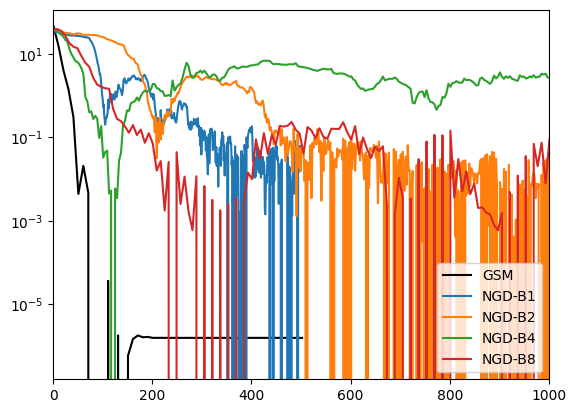

In [283]:
plt.plot(monitorg.nevals, monitorg.fkl, 'k', label='GSM')
# plt.plot(monitorn.nevals, monitorn.bkl, label='NGD')

for b in [1, 2, 4, 8]:
    m = ngd[b][-1]
    plt.plot(m.nevals, m.fkl, label=f'NGD-B{b}')
# plt.loglog()
plt.semilogy()
plt.legend()
plt.xlim(0, 1000)

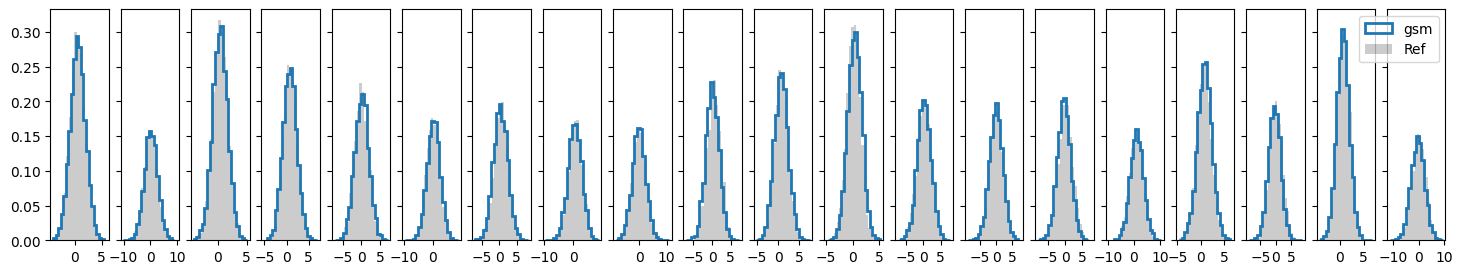

In [44]:
Dplot = min(20, D)
fig, ax = plt.subplots(1, Dplot, figsize=(18, 3), sharey=True)

for alg in ['gsm']:
    samples = np.random.multivariate_normal(params[alg][0], params[alg][1], 5000)
    for i in range(Dplot):
        ax[i].hist(samples[:, i], alpha=1., label=alg, histtype='step', bins=20, density=True, lw=2)
# for alg in params.keys():
#     samples = np.random.multivariate_normal(params[alg][0], params[alg][1], 5000)
#     for i in range(Dplot):
#         ax[i].hist(samples[:, i], alpha=1., label=alg, histtype='step', bins=20, density=True, lw=2)
                
for i in range(Dplot):
    ax[i].hist(ref_samples[:, i], alpha=0.2, label='Ref', color='k', bins=20, density=True)

    
ax[-1].legend()